# Convolutional Neural Network Model Training
Neste kernel eu testo modelos de rede neural convolucional na série temporal dos sorteios.

In [1]:
%pip install ipython-autotime  --upgrade
%load_ext autotime

time: 532 µs (started: 2023-08-09 17:39:35 +00:00)


In [2]:
from google.colab import drive, files
import pandas as pd
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
time: 5.31 s (started: 2023-08-09 17:39:37 +00:00)


In [3]:
cols = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8', 'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15']
raffles = pd.read_excel("/content/drive/MyDrive/datasets/loterias/raw/lotofacil.xlsx", usecols=cols)
raffles.head()

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
0,2,3,5,6,9,10,11,13,14,16,18,20,23,24,25
1,1,4,5,6,7,9,11,12,13,15,16,19,20,23,24
2,1,4,6,7,8,9,10,11,12,14,16,17,20,23,24
3,1,2,4,5,8,10,12,13,16,17,18,19,23,24,25
4,1,2,4,8,9,11,12,13,15,16,19,20,23,24,25


time: 3.91 s (started: 2023-08-09 17:39:44 +00:00)


# Dataset transformation
Vou criar dois tipos de conjuntos de dados onde ambos serão formados por imagens criadas a partir de cada sorteio.

No primeiro conjunto, cada sorteio formará uma matriz (5, 5) de valores 0 e 1 contendo os 25 números possíveis. Os indexes que contiverem 1 são aqueles onde o número foi sorteado e aqueles que contiverem 0 são os números que não foram sorteados.

No segundo conjunto, transformo cada sorteio em uma matriz de valores 1 ou 0 com 35 linhas e 35 colunas que representa uma imagem de cada sorteio. De certa forma a matriz continua sendo (5, 5), mas defini que cada elemento será uma matriz de (7, 7). Isso faz com que cada elemento que representa um número sorteado seja uma matriz cheia de 1s. O resultado final é a matriz (35, 35).

In [4]:
import numpy as np

time: 804 µs (started: 2023-08-09 17:39:51 +00:00)


In [5]:
size = len(raffles.index)
dataset = np.zeros(shape=(size, 25), dtype=int)
for i in range(0, len(raffles.index)):
  indexes = raffles.iloc[i].to_numpy() - 1
  dataset[i][indexes] = 1

print(raffles.iloc[0].to_numpy())
print(dataset[0])

[ 2  3  5  6  9 10 11 13 14 16 18 20 23 24 25]
[0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1]
time: 301 ms (started: 2023-08-09 17:39:54 +00:00)


## Conjunto 01

In [6]:
size = len(dataset)
img_shape = (5, 5)
dataset_imgs = np.zeros((size, *img_shape), dtype=int)
for i in range(size):
    dataset_imgs[i] = dataset[i].reshape(5, 5)

print(dataset_imgs[0])

[[0 1 1 0 1]
 [1 0 0 1 1]
 [1 0 1 1 0]
 [1 0 1 0 1]
 [0 0 1 1 1]]
time: 40.8 ms (started: 2023-08-09 17:39:58 +00:00)


## Conjunto 02

In [7]:
def enlarge_image(raffle):
  size = 7
  size_image = 5
  zeros = np.full(shape=(size, size), fill_value=0)
  ones  = np.full(shape=(size, size), fill_value=1)
  pixel = {0: zeros, 1: ones}

  # formação de cada linha
  pxl = pixel[raffle[0]]
  rows = list()
  for i in range(1, 25):
    if i % size_image != 0:
      pxl = np.concatenate([pxl, pixel[raffle[i]]], axis=1)
    else:
      rows.append(pxl)
      pxl = pixel[raffle[i]]
  rows.append(pxl) # última linha

  # formação da imagem
  img = rows[0]
  for r in range(1, len(rows)):
    img = np.concatenate([img, rows[r]], axis=0)
  return img

time: 1.42 ms (started: 2023-08-09 17:40:26 +00:00)


Formo o dataset de imagens

In [8]:
size = len(dataset)
img_shape = (35, 35)
dataset_imgs_bigger = np.zeros((size, *img_shape), dtype=int)
for i in range(size):
    img = enlarge_image(dataset[i])
    dataset_imgs_bigger[i] = img

time: 240 ms (started: 2023-08-09 17:40:29 +00:00)


# Data Visualization

In [9]:
import matplotlib.pyplot as plt

time: 625 µs (started: 2023-08-09 17:40:34 +00:00)


[ 2  3  5  6  9 10 11 13 14 16 18 20 23 24 25]


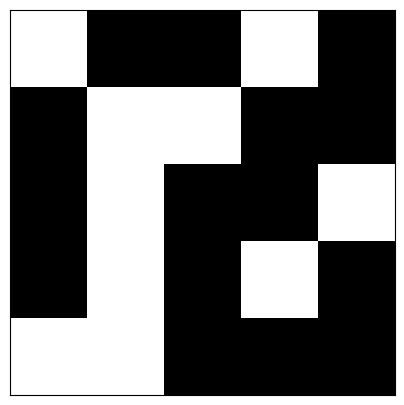

time: 354 ms (started: 2023-08-09 17:51:24 +00:00)


In [32]:
def plot_raffle(raffles_imgs, index):
  img = raffles_imgs[index]
  fig, ax = plt.subplots(figsize=(5, 5))
  cmap    = plt.cm.colors.ListedColormap(['white', 'black'])
  ax.imshow(img, cmap=cmap)
  plt.xticks([])
  plt.yticks([])
  plt.show()

index = 0
print(raffles.iloc[index].to_numpy())
plot_raffle(dataset_imgs_bigger, index)

# Data Labeling and Train/Test Split

Crio a label que será um numpy array de 25 posições representando cada um dos números possíveis. Os indexes que contiverem 1 são aqueles que foram sorteados, os que contiverem 0, não.

In [13]:
y = dataset.copy()

time: 2.23 ms (started: 2023-08-09 17:41:39 +00:00)


Vou ter que fazer a separação do conjunto em treino e teste manualmente.

In [14]:
train_size = 0.8
index      = int(len(dataset_imgs) * train_size)

X_train = dataset_imgs[:index]
X_test  = dataset_imgs[index:]

X_train_bigger = dataset_imgs_bigger[:index]
X_test_bigger  = dataset_imgs_bigger[index:]

# a label pode ser a mesma para ambos conjuntos de treinamento e teste
y_train = y[:index]
y_test  = y[index:]

time: 1.76 ms (started: 2023-08-09 17:41:40 +00:00)


Percorro o conjunto todo concatenando quatro sorteios consecutivos por vez para formar uma grande imagem (70, 70). Essas novas imagens formarão um novo dataset que será usado para treinar o modelo. A label de cada instância será o sorteio do quinto dia.

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

time: 5.96 s (started: 2023-08-09 17:41:45 +00:00)


In [23]:
ts_train = TimeseriesGenerator(data=X_train, targets=y_train, length=25, sampling_rate=1, stride=1, batch_size=2)
ts_test  = TimeseriesGenerator(data=X_test, targets=y_test, length=25, sampling_rate=1, stride=1, batch_size=2)
print(ts_train[0][0].shape)
print(ts_test[0][1].shape)

(2, 25, 5, 5)
(2, 25)
time: 12 ms (started: 2023-08-09 17:48:50 +00:00)


In [24]:
def concatenate_imgs(raffles, square_size):
  rfl = raffles[0]
  rows = list()
  for i in range(1, len(raffles)):
    if i % square_size != 0:
      rfl = np.concatenate([rfl, raffles[i]], axis=1)
    else:
      rows.append(rfl)
      rfl = raffles[i]
  rows.append(rfl) # adiciona a última linha

  img = rows[0]
  for r in range(1, len(rows)):
    img = np.concatenate([img, rows[r]], axis=0)
  return img


x = list()
y = list()
for b in ts_train:
  for imgs, label in zip(b[0], b[1]):
    x.append(concatenate_imgs(imgs, 5))
    y.append(label)



print(len(x))
print(len(y))

2275
2275
time: 328 ms (started: 2023-08-09 17:48:57 +00:00)


(25, 25)


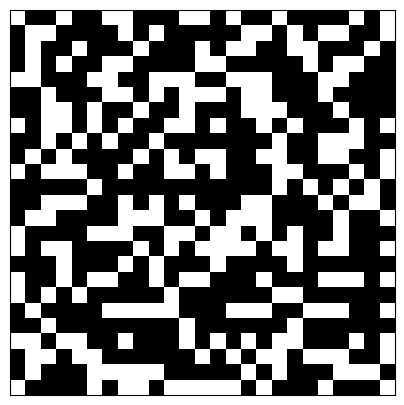

time: 96 ms (started: 2023-08-09 17:49:04 +00:00)


In [25]:
index = 0
print(x[index].shape)
plot_raffle(x, index)

Agora, é preciso criar também manualmente a forward feature, que é a própria label indicando o sorteio do dia seguinte. Além disso, também vou remover os valores que se tornariam NaN caso eu fizesse isso usando o Pandas.

# Model Training

In [ ]:
from keras.callbacks              import EarlyStopping, ReduceLROnPlateau
from keras.layers                 import Dense, LSTM
from keras.models                 import Sequential
from keras.optimizers             import Nadam
from sklearn.metrics              import accuracy_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
%matplotlib inline

time: 1.59 s (started: 2023-08-07 20:30:40 +00:00)


Neural Networks's Callbacks

In [ ]:
#callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

time: 9.75 ms (started: 2023-08-05 16:31:07 +00:00)


Funções de resultado de avaliação de um modelo.

In [ ]:
def plot_evaluation(history, task):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  if task == 'classification':
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  elif task == 'regression':
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
  plt.legend()



def show_evaluation(model, dataset, task):
  result = model.evaluate(dataset, verbose=False)
  print(f'Loss:     {result[0]:.2f}')
  if task == 'classification':
    print(f'Accuracy: {result[1]:.2f}')
  elif task == 'regression':
    print(f'MSE:      {result[1]:.2f}')

time: 1.35 ms (started: 2023-08-05 16:31:08 +00:00)
